<a href="https://colab.research.google.com/github/botingchen/DCGAN_Style_Transfer/blob/main/src/AI_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pathlib
import torch
import torchvision


5734


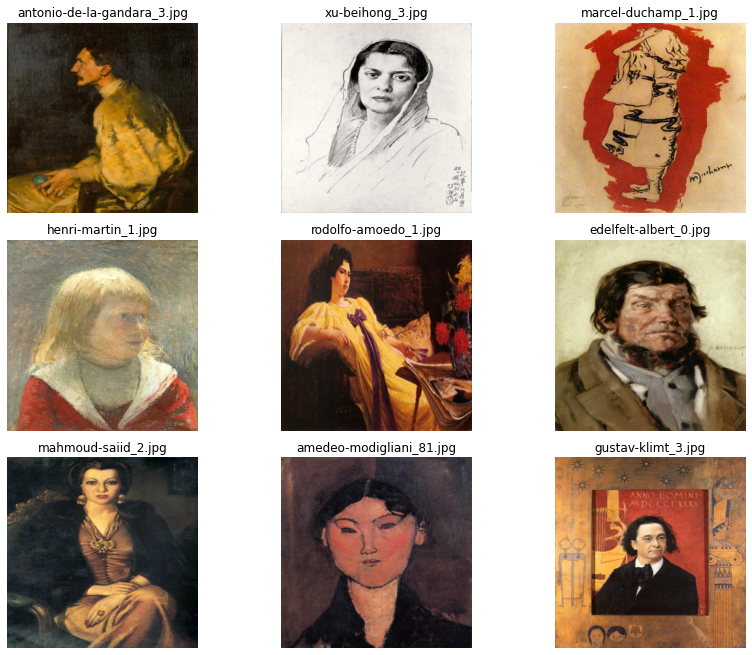

In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks_Dataset/AI_Final_Datasets/Images/'
images = os.listdir(PATH)
print(len(images))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
for indx, axis in enumerate(axes.flatten()):
    if indx == 1500:
      break
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
from torchvision.transforms import transforms
batch_size = 32
image_size = 64

transform = torchvision.transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Colab_Notebooks_Dataset/AI_Final_Datasets", transform=transform)
dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


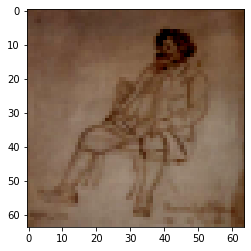

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


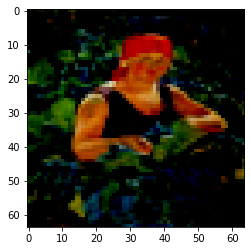

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


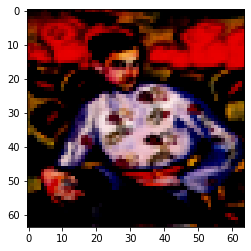

In [ ]:
for i in range(3):
  plt.imshow(imgs[i])
  plt.show()

In [ ]:
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5 
d_lr = 0.0002
g_lr = 0.0001
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
def weight_inits(m):
  classname = m.__class__.__name__
  # print(classname)
  if classname.find('Conv') != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.normal_(m.bias.data, 0)

In [ ]:
class Generator(torch.nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = torch.nn.Sequential(
      # input is Z, going into a convolution
      torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
      torch.nn.BatchNorm2d(ngf * 8),
      torch.nn.ReLU(True),
      # state size. (ngf*8) x 4 x 4
      torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      torch.nn.BatchNorm2d(ngf * 4),
      torch.nn.ReLU(True),
      # state size. (ngf*4) x 8 x 8
      torch.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      torch.nn.BatchNorm2d(ngf * 2),
      torch.nn.ReLU(True),
      # state size. (ngf*2) x 16 x 16
      torch.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
      torch.nn.BatchNorm2d(ngf),
      torch.nn.ReLU(True),
      # state size. (ngf) x 32 x 32
      torch.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
      torch.nn.Tanh()
      # state size. (nc) x 64 x 64
    )
  def forward(self, input):
    return self.main(input)


In [ ]:
NetG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
  NetG = torch.nn.DataParallel(NetG, list(range(ngpu)))
NetG.apply(weight_inits)
print(NetG)
print("device: ", device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(torch.nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = torch.nn.Sequential(
      # input is (nc) x 64 x 64
      torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf) x 32 x 32
      torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      torch.nn.BatchNorm2d(ndf * 2),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2) x 16 x 16
      torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      torch.nn.BatchNorm2d(ndf * 4),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 8 x 8
      torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      torch.nn.BatchNorm2d(ndf * 8),
      torch.nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 4 x 4
      torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
      torch.nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [ ]:
NetD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
  NetD = torch.nn.DataParallel(NetD, list(range(ngpu)))
NetD.apply(weight_inits)
print(NetD)
# print("device: ", device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
loss_fn = torch.nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerG = torch.optim.Adam(NetG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(NetD.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
num_epochs = 500
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        NetD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = NetD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = NetG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = NetD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        NetG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = NetD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = NetG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/180]	Loss_D: 2.1998	Loss_G: 10.7316	D(x): 0.5806	D(G(z)): 0.7480 / 0.0000
[0/500][50/180]	Loss_D: 0.1068	Loss_G: 10.1992	D(x): 0.9108	D(G(z)): 0.0001 / 0.0000
[0/500][100/180]	Loss_D: 0.0194	Loss_G: 11.1177	D(x): 0.9814	D(G(z)): 0.0000 / 0.0000
[0/500][150/180]	Loss_D: 0.0732	Loss_G: 6.7342	D(x): 0.9925	D(G(z)): 0.0633 / 0.0013
[1/500][0/180]	Loss_D: 0.4072	Loss_G: 5.5709	D(x): 0.7805	D(G(z)): 0.0442 / 0.0066
[1/500][50/180]	Loss_D: 0.8556	Loss_G: 12.5699	D(x): 0.9889	D(G(z)): 0.4905 / 0.0000
[1/500][100/180]	Loss_D: 0.2379	Loss_G: 4.8526	D(x): 0.8656	D(G(z)): 0.0522 / 0.0173
[1/500][150/180]	Loss_D: 0.3742	Loss_G: 6.1390	D(x): 0.7644	D(G(z)): 0.0173 / 0.0039
[2/500][0/180]	Loss_D: 1.7134	Loss_G: 11.3102	D(x): 0.9318	D(G(z)): 0.6105 / 0.0000
[2/500][50/180]	Loss_D: 0.3557	Loss_G: 3.6580	D(x): 0.7971	D(G(z)): 0.0618 / 0.0314
[2/500][100/180]	Loss_D: 0.5045	Loss_G: 4.7457	D(x): 0.8617	D(G(z)): 0.2622 / 0.0190


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
print(img_list[0].shape)
torch.save(img_list,'/content/drive/MyDrive/Colab_Notebooks_Dataset/output64_k5_z64/img_list.pt')

In [ ]:
x = torch.load("/content/drive/MyDrive/Colab_Notebooks_Dataset/output64_k5_z64/img_list.pt")
plt.imshow(np.transpose(x[0],(1,2,0)))